### MAXIMIZING FAIRNESS UNDER ACCURACY CONSTRAINTS


In [128]:

#Load data 
import pandas as pd 
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
import numpy as np
from scipy.optimize import minimize # for loss func minimization
from collections import defaultdict
from sklearn.metrics import classification_report, confusion_matrix
from copy import deepcopy
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt # for plotting stuff
from sklearn.metrics import log_loss
from scipy import optimize
import copy
import itertools
from random import seed, shuffle
import math
from sklearn.svm import SVC
from sklearn.utils import shuffle

In [179]:
# Logistic regression prints lots of unfriendly warnings for the final notebook
import warnings
warnings.filterwarnings('ignore')

In [180]:
#universal 
#df = pd.read_csv('https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv')

Writing all the important functions as given by the Paper

In [181]:
#We Calculate the P% as given by the paper -Protected are those between age 25 and 60 = 1 and Unprotected are = 0 
def p_rule_percent(sensitive_col, y_predicted):
    
    protected = np.where(sensitive_col == 1)[0]  #returns the index of the protected
    unprotected = np.where(sensitive_col != 1)[0] #returns the index of the unprotected
    prediction_protected = np.where(y_predicted[protected]==1)
    prediction_unprotected = np.where(y_predicted[unprotected]==1)

    total_protected = protected.shape[0]
    total_unprotected = unprotected.shape[0]

    total_protected_pred = prediction_protected[0].shape[0]
    total_unprotected_pred = prediction_unprotected[0].shape[0]

    protected_ratio = total_protected_pred/total_protected
    unprotected_ratio = total_unprotected_pred/total_unprotected
    
    p_percent_ratio = protected_ratio/unprotected_ratio
    return p_percent_ratio, protected_ratio, unprotected_ratio 
    

In [182]:
# function to optimize

def optimize_function(w, x, protected_var):
    dist_bound = np.dot(w, X_train.T)
    protected_cov = (protected_var - np.mean(protected_var)) * dist_bound
    return float(abs(sum(protected_cov))) / float(X_train.shape[0])

#On page 4, equation (5) we get the logistic loss ,Fined-Grained Accuracy Constraint, Page 5 Equation 8

def log_loss_constraint(weights, x, y, gamma):
    prod = np.dot(x, weights.reshape(X_train.shape[1],1))
    pred_probability = 1/(1+np.exp(-prod))
    predicted_classes = np.concatenate((1-pred_probability, pred_probability), axis = 1)
    loss = log_loss(y, predicted_classes)
    return (1+gamma)*actual_train_loss - loss 

In [183]:
#Accuracy Calculation
def accuracy(w, x, y):
    shape = x.shape[1]
    pred = np.dot(x, w.reshape(x.shape[1],1))
    pred_prob = 1/(1+ np.exp(-pred))
    pred_prob[pred_prob>=0.5] = 1
    pred_prob[pred_prob<0.5] = 0
    value = np.where(pred_prob== y.reshape(pred_prob.shape))
    accuracy = value[0].shape[0]/pred_prob.shape[0]
    return accuracy, pred_prob

optimization reference is provided in the link - [https://towardsdatascience.com/optimization-with-scipy-and-application-ideas-to-machine-learning-81d39c7938b8]. It uses the concept of scipy optimization to add constraints as a pre-defined function.


For the optimization method, SLSQP method is used which stands for Sequential Least-Square Quadratic Programming. We will do the number of iterations of 1000, and then add the optimization function and the log loss constraint as the parameters.

In [184]:
def optimization(x_train, y_train, x_test, y_test, protected_attr, protected_attr_test, gamma, optimal_weights):
    cons = {'type':'ineq', 'fun': log_loss_constraint, 'args': (x_train, y_train, gamma)}

    result = optimize.minimize(optimize_function, x0=optimal_weights,args= (x_train,protected_attr),method='SLSQP',constraints=cons,options={'maxiter':10000})
    
    accuracy_train, pred_y = accuracy(result.x, x_train, y_train)
    p_rule_val, prot_perc, nonp_perc = p_rule_percent(protected_attr, pred_y)
    
    accuracy_test, y_pred_test = accuracy(result.x, x_test, y_test)
    p_rule_val_test, prot_perc_test, nonp_perc_test = p_rule_percent(protected_attr_test, y_pred_test)
    
    print("\nTest Accuracy for gamma ",gamma,": ",accuracy_test)
    print("P Rule percent: ", p_rule_val_test)
    
    return accuracy_train,pred_y, p_rule_val, accuracy_test, p_rule_val_test, y_pred_test

The paper implements  Algorithm 3 on the Bank data to represent  how the model constraints were put into place. Hence we  first implement the algorithm mentioned by them on the Bank data. Then we will move on to the COMPAS Dataset.

Here we we will perform evaluation on the Bank data as given in  the paper

In [185]:
df_bank = pd.read_csv("/content/bank-full.csv", delimiter=";")


In [186]:
df_bank = df_bank.dropna()
df_bank

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


In [187]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
target = encoder.fit_transform(df_bank['y'])
sensitive_age = df_bank["age"].apply(lambda x: 1 if 25<= x <= 60 else 0)
df_bank = df_bank.drop(columns = ["age", "y", "day", "month"])

In [188]:
columns = ['job', 'marital', 'education','contact','poutcome']
for c in columns: 
    dummies = pd.get_dummies(df_bank[c])
    df_bank = pd.merge(df_bank, dummies, left_index = True, right_index = True)
    df_bank = df_bank.drop(columns = [c])
df_bank

,default,balance,housing,loan,duration,campaign,pdays,previous,admin.,blue-collar,entrepreneur,housemaid,management,retired,self-employed,services,student,technician,unemployed,unknown_x,divorced,married,single,primary,secondary,tertiary,unknown_y,cellular,telephone,unknown_x,failure,other,success,unknown_y
0,no,2143,yes,no,261,1,-1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1
1,no,29,yes,no,151,1,-1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1
2,no,2,yes,yes,76,1,-1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1
3,no,1506,yes,no,92,1,-1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1
4,no,1,no,no,198,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,no,825,no,no,977,3,-1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1
45207,no,1729,no,no,456,2,-1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1
45208,no,5715,no,no,1127,5,184,3,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0
45209,no,668,no,no,508,4,-1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1


In [189]:
#Encoding the categorical values

df_bank['default'] = encoder.fit_transform(df_bank['default'])
df_bank['housing'] = encoder.fit_transform(df_bank['housing'])
df_bank['loan'] = encoder.fit_transform(df_bank['loan'])

In [190]:
df_bank, target, sensitive_age = shuffle(df_bank, target, sensitive_age, random_state=123) #randomizing and shuffling  

In [191]:

df_bank

,default,balance,housing,loan,duration,campaign,pdays,previous,admin.,blue-collar,entrepreneur,housemaid,management,retired,self-employed,services,student,technician,unemployed,unknown_x,divorced,married,single,primary,secondary,tertiary,unknown_y,cellular,telephone,unknown_x,failure,other,success,unknown_y
7281,0,589,1,0,535,2,-1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1
19469,0,649,0,0,64,2,-1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1
31637,0,1972,0,0,97,1,-1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1
22484,0,1,0,0,239,4,-1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1
35919,0,-808,1,0,75,4,-1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7763,0,3674,1,0,886,3,-1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1
15377,0,635,1,0,359,1,-1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1
17730,0,3664,0,0,274,1,-1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1
28030,0,8585,0,0,201,2,-1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1


In [192]:
df_bank = df_bank.to_numpy()
sensitive_age = sensitive_age.to_numpy()

In [193]:
X = df_bank
Y = target
train_test_split = int(len(X)*.80) 
X_train1 =X[:train_test_split]
Y_train1 = Y[:train_test_split]
sensitive_age_train1 = sensitive_age[:train_test_split]

X_test =X[train_test_split:]
Y_test = Y[train_test_split:]
sensitive_age_test = sensitive_age[train_test_split:]

train_test_split = int(len(X_train1)*.75) 
X_train =X_train1[:train_test_split]
Y_train = Y_train1[:train_test_split]
sensitive_age_train = sensitive_age_train1[:train_test_split]

X_val =X_train1[train_test_split:]
Y_val = Y_train1[train_test_split:]
sensitive_age_val = sensitive_age_train1[train_test_split:]

In [194]:
print("Bank Dataset!")
print("X_train Shape: ", X_train.shape)
print("Y_train Shape: ", Y_train.shape)
print("X_val Shape: ", X_val.shape)
print("Y_val Shape: ", Y_val.shape)
print("X_test Shape: ", X_test.shape)
print("X_test Shape: ", Y_test.shape)

Bank Dataset!
X_train Shape:  (27126, 34)
Y_train Shape:  (27126,)
X_val Shape:  (9042, 34)
Y_val Shape:  (9042,)
X_test Shape:  (9043, 34)
X_test Shape:  (9043,)


In [195]:
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression().fit(X_train, Y_train)
print(classification_report(Y_val, lr.predict(X_val)))   #Working on the validation data

              precision    recall  f1-score   support

           0       0.91      0.98      0.94      8017
           1       0.59      0.22      0.32      1025

    accuracy                           0.89      9042
   macro avg       0.75      0.60      0.63      9042
weighted avg       0.87      0.89      0.87      9042



In [196]:
train_accuracy = lr.score(X_train, Y_train)
val_accuracy = lr.score(X_val, Y_val)

In [197]:
print("Training Accuracy: ", train_accuracy)
print("Validation Accuracy: ", val_accuracy)

Training Accuracy:  0.8912851139128511
Validation Accuracy:  0.8944923689449237


In [198]:
y_predicted = lr.predict(X_train)

In [199]:
p_percent, protected_ratio, unprotected_ratio = p_rule_percent(sensitive_age_train, y_predicted)

In [200]:
print("P% for the Bank Dataset without optimization: ",round(p_percent*100,2),"%")

P% for the Bank Dataset without optimization:  38.96 %


In [201]:
actual_train_loss = log_loss(Y_train, lr.predict_proba(X_train))
print("Actual Train Loss: ", actual_train_loss)

Actual Train Loss:  0.2674057721051699


In [202]:
#Now s=we start with the optimization as described in the paper and adding a Bias_factor to the data for the decision boundary

bias_factor_train = np.ones(X_train.shape[0]).reshape(X_train.shape[0],1)
bias_factor_val = np.ones(X_val.shape[0]).reshape(X_val.shape[0],1)
bias_factor_test = np.ones(X_test.shape[0]).reshape(X_test.shape[0],1)

X_val =  np.concatenate((X_val, bias_factor_val), axis = 1)
X_test =  np.concatenate((X_test, bias_factor_test), axis = 1)
X_train = np.concatenate((X_train, bias_factor_train), axis = 1)

In [203]:
#Creating the Weights Dataframe
weights_df = np.concatenate((lr.coef_, lr.intercept_.reshape(1,1)),axis=1)

Perform Hyperparamter Tuning with Different Gammas

In [204]:
gamma_list = [0.1,0.15,0.2, 0.25]
accuracy_list, p_list =  [],[]
y_pred_train_list = []
y_pred_test_list = []
accuracy_list_test, p_test = [],[]
for g in gamma_list:    
    (accuracy_train, pred_y, p_rule_val, accuracy_test, p_rule_val_test, y_pred_test) = optimization(X_train, Y_train, X_test, Y_test,sensitive_age_train,sensitive_age_test,g,
                                                                                    weights_df)
                                                                                     
    accuracy_list.append(accuracy_train)
    y_pred_train_list.append(pred_y)
    p_list.append(p_rule_val)
    accuracy_list_test.append(accuracy_test)
    y_pred_test_list.append(y_pred_test)
    p_test.append(p_rule_val_test)


Test Accuracy for gamma  0.1 :  0.8949463673559659
P Rule percent:  0.849344360240244

Test Accuracy for gamma  0.15 :  0.8933982085591065
P Rule percent:  0.9556093623890233

Test Accuracy for gamma  0.2 :  0.8926241291606768
P Rule percent:  0.8466593938748902

Test Accuracy for gamma  0.25 :  0.8988167643481145
P Rule percent:  0.42173576452372713


Train Accuracy and P% Rule


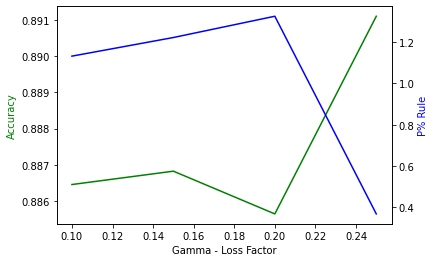

In [205]:
import matplotlib.pyplot as plt
print("Train Accuracy and P% Rule")
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(gamma_list, accuracy_list , 'g-')
ax2.plot(gamma_list, p_list, 'b-')
ax1.set_xlabel('Gamma - Loss Factor')
ax1.set_ylabel('Accuracy', color='g')
ax2.set_ylabel('P% Rule', color='b')

plt.show()

Train Accuracy and P% Rule


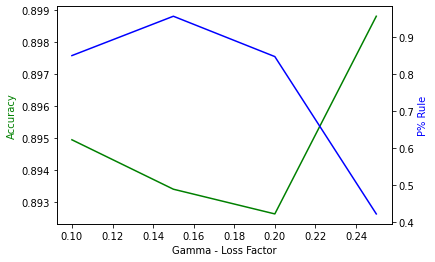

In [206]:
import matplotlib.pyplot as plt
print("Train Accuracy and P% Rule")
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(gamma_list, accuracy_list_test , 'g-')
ax2.plot(gamma_list, p_test, 'b-')
ax1.set_xlabel('Gamma - Loss Factor')
ax1.set_ylabel('Accuracy', color='g')
ax2.set_ylabel('P% Rule', color='b')

plt.show()

COMPAS Dataset

In [207]:
import pandas as pd
import numpy as np
import math
import copy
import itertools
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(18, 16), dpi=180)
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score

pd.set_option('display.max_columns', None)

<Figure size 3240x2880 with 0 Axes>

In [208]:
compas= ('https://raw.githubusercontent.com/'
        'propublica/compas-analysis/master/compas-scores-two-years.csv')
feature = ['age', 'c_charge_degree', 'race', 'v_score_text', 'sex', 'priors_count', 
           'days_b_screening_arrest', 'decile_score', 'is_recid', 'two_year_recid','c_jail_in', 'c_jail_out']
raw = pd.read_csv(compas)[feature]
raw

,age,c_charge_degree,race,v_score_text,sex,priors_count,days_b_screening_arrest,decile_score,is_recid,two_year_recid,c_jail_in,c_jail_out
0,69,F,Other,Low,Male,0,-1.0,1,0,0,2013-08-13 06:03:42,2013-08-14 05:41:20
1,34,F,African-American,Low,Male,0,-1.0,3,1,1,2013-01-26 03:45:27,2013-02-05 05:36:53
2,24,F,African-American,Low,Male,4,-1.0,4,1,1,2013-04-13 04:58:34,2013-04-14 07:02:04
3,23,F,African-American,Medium,Male,1,NaN,8,0,0,NaN,NaN
4,43,F,Other,Low,Male,2,NaN,1,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
7209,23,F,African-American,Medium,Male,0,-1.0,7,0,0,2013-11-22 05:18:27,2013-11-24 02:59:20
7210,23,F,African-American,Medium,Male,0,-1.0,3,0,0,2014-01-31 07:13:54,2014-02-02 04:03:52
7211,57,F,Other,Low,Male,0,-1.0,1,0,0,2014-01-13 05:48:01,2014-01-14 07:49:46
7212,33,M,African-American,Low,Female,3,-1.0,2,0,0,2014-03-08 08:06:02,2014-03-09 12:18:04


In [209]:
df = raw[(raw.race == 'Caucasian') | (raw.race == 'African-American')]
df = df[(df.days_b_screening_arrest < 30) & (df.days_b_screening_arrest >= -30)]
df.drop(columns=['days_b_screening_arrest'], inplace = True)
df = df[df.is_recid != -1]
df = df[df.c_charge_degree != 'O']
df['length_of_stay'] = (pd.to_datetime(df["c_jail_out"]) - pd.to_datetime(df['c_jail_in'])).dt.days
df.drop(columns=['c_jail_in', 'c_jail_out'], inplace=True)

df

,age,c_charge_degree,race,v_score_text,sex,priors_count,decile_score,is_recid,two_year_recid,length_of_stay
1,34,F,African-American,Low,Male,0,3,1,1,10
2,24,F,African-American,Low,Male,4,4,1,1,1
6,41,F,Caucasian,Low,Male,14,6,1,1,6
8,39,M,Caucasian,Low,Female,0,1,0,0,2
10,27,F,Caucasian,Low,Male,0,4,0,0,1
...,...,...,...,...,...,...,...,...,...,...
7207,30,M,African-American,Low,Male,0,2,1,1,0
7208,20,F,African-American,High,Male,0,9,0,0,0
7209,23,F,African-American,Medium,Male,0,7,0,0,1
7210,23,F,African-American,Medium,Male,0,3,0,0,1


In [210]:
## Encoding

catgorical = df.columns[df.dtypes == 'object']
for fea in catgorical:
    new_fea = LabelEncoder().fit_transform(df[fea])
    df[fea] = new_fea
    
df['age_cat'] = pd.cut(df['age'], bins = [0, 25, 45, 100], labels = [0, 1, 2])
df['priors_count_cat'] = pd.cut(df['priors_count'], bins = [-5, 0, 3, np.inf], labels = [0, 1, 2])
df['length_cat'] = pd.cut(df['length_of_stay'], bins = [0, 7, 90, np.inf], labels = [0, 1, 2])
df_clean = df[['race', 'age_cat', 'c_charge_degree', 'sex', 'priors_count_cat', 'length_cat', 'two_year_recid']]
df_clean = df_clean.dropna()




In [211]:
# train_test_split

y = df_clean.two_year_recid
X = df_clean.drop(columns=['two_year_recid'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/7, stratify=y, random_state=123)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=1/6, 
                                                   stratify=y_train, random_state = 123)

In [212]:
# Race as protected attributes(sensitive features)

X_train_sen = np.array(X_train['race'])
X_train = np.array(X_train.drop(columns = ['race']))
X_val_sen = np.array(X_val['race'])
X_val = np.array(X_val.drop(columns = ['race']))

# For calculating calibration, split the test dataset to different race
X_test_AA = X_test[X_test.race == 0]
race_test_AA = np.array(X_test_AA['race'])
X_test_AA = np.array(X_test_AA.drop(columns = ['race']))
X_test_CA = X_test[X_test.race == 1]
race_test_CA = np.array(X_test_CA['race'])
X_test_CA = np.array(X_test_CA.drop(columns = ['race']))


y_train = np.array(y_train)
y_val = np.array(y_val)
y_test_AA = np.array(y_test[X_test.race == 0])
y_test_CA = np.array(y_test[X_test.race == 1])

X_test_sen = np.array(X_test['race'])
X_test = np.array(X_test.drop(columns = ['race']))

#X_test = np.array(X_test)
y_test = np.array(y_test)

In [213]:
race_train = X_train_sen
race_val = X_val_sen
race_test = X_test_sen

In [214]:
lr = LogisticRegression().fit(X_train, y_train)
print(classification_report(y_val, lr.predict(X_val)))   #Working on the validation data

              precision    recall  f1-score   support

           0       0.67      0.67      0.67       237
           1       0.69      0.69      0.69       250

    accuracy                           0.68       487
   macro avg       0.68      0.68      0.68       487
weighted avg       0.68      0.68      0.68       487



In [215]:
accuracy_train_compas = lr.score(X_train, y_train)
p_percent_compas = p_rule_percent(race_train, lr.predict(X_train))

In [216]:
accuracy_val_compas = lr.score(X_val, y_val)
p_percent_compas_val = p_rule_percent(race_val, lr.predict(X_val))

In [217]:
print("Scores for Train:")
print("Accuracy: ", accuracy_train_compas)
print("P%: ", round(p_percent_compas[0]*100,2),"%")
print("\nScores for Val:")
print("Accuracy: ", accuracy_val_compas)
print("P%: ", round(p_percent_compas_val[0]*100,2),"%")

Scores for Train:
Accuracy:  0.6540673788003287
P%:  66.8 %

Scores for Val:
Accuracy:  0.6817248459958932
P%:  66.4 %


In [218]:
actual_train_loss = log_loss(y_train, lr.predict_proba(X_train))
print("Actual Train Loss: ", actual_train_loss)

Actual Train Loss:  0.6353911517542475


In [219]:
y_pred__model1_AA = lr.predict(X_test_AA)
accuracy_model1_AA = lr.score(X_test_AA, y_test_AA)

y_pred__model1_CA = lr.predict(X_test_CA)
accuracy_model1_CA = lr.score(X_test_CA, y_test_CA)

In [220]:
#Test Accuracy without Constraint and constant Gamma
accuracy_test_compas = lr.score(X_test, y_test)
y_pred_model1 = lr.predict(X_test)

In [221]:
#Now s=we start with the optimization as described in the paper and Adding a Bias_factor to the data for the decision boundary

bias_factor_train = np.ones(X_train.shape[0]).reshape(X_train.shape[0],1)
bias_factor_val = np.ones(X_val.shape[0]).reshape(X_val.shape[0],1)
bias_factor_test = np.ones(X_test.shape[0]).reshape(X_test.shape[0],1)

bias_factor_test_AA = np.ones(X_test_AA.shape[0]).reshape(X_test_AA.shape[0],1)
bias_factor_test_CA = np.ones(X_test_CA.shape[0]).reshape(X_test_CA.shape[0],1)


X_val =  np.concatenate((X_val, bias_factor_val), axis = 1)
X_test =  np.concatenate((X_test, bias_factor_test), axis = 1)
X_train = np.concatenate((X_train, bias_factor_train), axis = 1)

X_test_AA =  np.concatenate((X_test_AA, bias_factor_test_AA), axis = 1)
X_test_CA =  np.concatenate((X_test_CA, bias_factor_test_CA), axis = 1)

In [222]:
#Creating the Weights Dataframe
weights_df = np.concatenate((lr.coef_, lr.intercept_.reshape(1,1)),axis=1)

In [223]:
gamma_list = [0.1,0.15,0.2, 0.25]

accuracy_list, p_list =  [],[]
accuracy_list_test, p_test = [],[]
y_pred_train_list = []
y_pred_test_list = []
for g in gamma_list:    
    (accuracy_train, pred_y, p_rule_val, accuracy_test, p_rule_val_test,y_pred_test) = optimization(X_train, 
                                                                                    y_train, 
                                                                                    X_test, 
                                                                                    y_test, 
                                                                                    race_train,
                                                                                    race_test,
                                                                                    g,
                                                                                    weights_df)
                                                                                     
    accuracy_list.append(accuracy_train)
    y_pred_train_list.append(pred_y)
    p_list.append(p_rule_val)

    accuracy_list_test.append(accuracy_test)
    y_pred_test_list.append(y_pred_test)
    p_test.append(p_rule_val_test)


Test Accuracy for gamma  0.1 :  0.5585215605749486
P Rule percent:  0.974138438880707

Test Accuracy for gamma  0.15 :  0.49691991786447637
P Rule percent:  0.7640816326530613

Test Accuracy for gamma  0.2 :  0.4948665297741273
P Rule percent:  1.2966233766233766

Test Accuracy for gamma  0.25 :  0.4948665297741273
P Rule percent:  1.2966233766233766


Train Accuracy and P% Rule


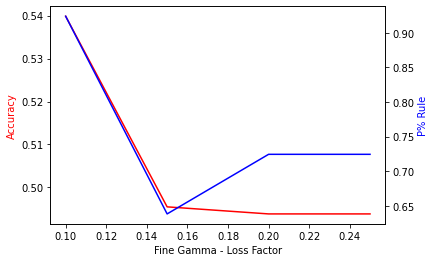

In [224]:
import matplotlib.pyplot as plt
print("Train Accuracy and P% Rule")
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(gamma_list, accuracy_list , 'r-')
ax2.plot(gamma_list, p_list, 'b-')

ax1.set_xlabel('Fine Gamma - Loss Factor')
ax1.set_ylabel('Accuracy', color='r')
ax2.set_ylabel('P% Rule', color='b')

plt.show()

Test Accuracy and P% Rule


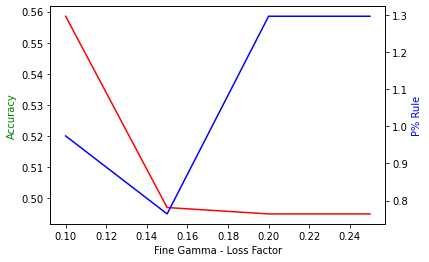

In [225]:
import matplotlib.pyplot as plt
print("Test Accuracy and P% Rule")
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(gamma_list, accuracy_list_test , 'r-')
ax2.plot(gamma_list, p_test, 'b-')

ax1.set_xlabel('Fine Gamma - Loss Factor')
ax1.set_ylabel('Accuracy', color='g')
ax2.set_ylabel('P% Rule', color='b')

plt.show()

In [226]:
acc_total = 0
for x in accuracy_list_test:
    acc_total = acc_total + x
accuracy_test_constrained = acc_total/len(accuracy_list_test)

In [227]:
print("Accuracy of the Actual Model: ", accuracy_test_compas)
print("Accuracy of the Constrained Model: ", accuracy_test_constrained)

Accuracy of the Actual Model:  0.6796714579055442
Accuracy of the Constrained Model:  0.5112936344969199
